# Search-5 : Algorithmes Genetiques

**Navigation** : [<< Search-4 LocalSearch](Search-4-LocalSearch.ipynb) | [Index](../README.md) | [Search-6 CSP-Fundamentals >>](Search-6-CSP-Fundamentals.ipynb)

## Objectifs d'apprentissage

A la fin de ce notebook, vous saurez :
1. **Decrire** le cycle d'un algorithme genetique (selection, crossover, mutation, evaluation)
2. **Implementer** un GA complet from scratch pour un probleme d'optimisation combinatoire
3. **Utiliser** les frameworks DEAP et PyGAD pour resoudre des problemes concrets
4. **Analyser** l'impact des parametres (taille de population, taux de mutation, methode de selection) sur la convergence
5. **Comparer** les operateurs genetiques (selection, crossover, mutation) et leurs compromis

### Prerequis
- Notebook Search-4-LocalSearch complete (recherche locale, Hill Climbing, recuit simule)
- Python 3.10+ (classes, numpy, matplotlib)
- Notions de base en optimisation (paysage de fitness, optima locaux)

### Duree estimee : 50 minutes

---

## 1. Introduction (~5 min)

### De l'evolution naturelle a l'optimisation

Les **algorithmes genetiques** (AG) sont des metaheuristiques inspirees de la theorie de l'evolution de Darwin. Contrairement aux methodes de recherche locale etudiees dans Search-4 (Hill Climbing, Recuit Simule, Tabou) qui manipulent une **seule solution** a la fois, les AG travaillent avec une **population** de solutions candidates qui evolue au fil des generations.

### Vocabulaire : de la biologie a l'informatique

| Biologie | Algorithme Genetique | Description |
|----------|---------------------|-------------|
| Individu / Organisme | Solution candidate | Un point dans l'espace de recherche |
| Chromosome | Encodage | Representation de la solution (binaire, reel, permutation) |
| Gene | Variable de decision | Un element du chromosome |
| Allele | Valeur d'un gene | Valeur concrete d'une variable |
| Population | Ensemble de solutions | Groupe de solutions explorees simultanement |
| Fitness | Fonction objectif | Qualite d'une solution |
| Generation | Iteration | Un cycle complet de l'algorithme |

### Cycle de l'algorithme genetique

Le cycle d'un AG se decompose en etapes repetees a chaque generation :

```
Population initiale (aleatoire)
        |
        v
   [Evaluation] <-----+
        |              |
        v              |
   [Selection]         |
        |              |
        v              |
   [Crossover]         |
        |              |
        v              |
   [Mutation]          |
        |              |
        v              |
   Nouvelle generation +
        |
   Condition d'arret ?
        |
        v
   Meilleur individu
```

### Pourquoi les AG ?

| Avantage | Detail |
|----------|--------|
| **Diversite** | La population explore plusieurs regions de l'espace simultanement |
| **Evasion** | Le crossover combine des solutions eloignees, echappant aux optima locaux |
| **Generalite** | Applicable a tout probleme ou l'on peut encoder une solution et definir un fitness |
| **Parallelisable** | L'evaluation de chaque individu est independante |

In [1]:
# Imports
import sys
import time
import random
import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

# Helpers partages de la serie Search
sys.path.insert(0, '..')
from search_helpers import draw_fitness_landscape, benchmark_table, plot_benchmark

# Reproductibilite
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("Environnement pret.")

Environnement pret.


---

## 2. Composants d'un AG (~10 min)

### 2.1 Encodage du chromosome

Le choix de l'encodage est crucial : il determine comment une solution est representee et comment les operateurs genetiques agissent.

| Encodage | Representation | Exemple de probleme |
|----------|---------------|---------------------|
| **Binaire** | Chaine de 0 et 1 | OneMax, sac a dos |
| **Entier** | Vecteur d'entiers | Allocation de ressources |
| **Reel** | Vecteur de flottants | Optimisation continue (Rastrigin, Rosenbrock) |
| **Permutation** | Permutation d'indices | TSP, ordonnancement |

In [2]:
# Exemples d'encodages
print("Exemples d'encodages de chromosomes")
print("=" * 55)

# Binaire : maximiser le nombre de 1 (OneMax)
binary_chromosome = [1, 0, 1, 1, 0, 1, 0, 1, 1, 1]
print(f"Binaire (OneMax)    : {binary_chromosome}  -> fitness = {sum(binary_chromosome)}")

# Entier : affectation de couleurs (graph coloring)
integer_chromosome = [0, 2, 1, 0, 2, 1]
print(f"Entier (coloration) : {integer_chromosome}  -> 3 couleurs")

# Reel : position dans un espace continu
real_chromosome = [1.23, -0.45, 2.78, -1.92]
print(f"Reel (optimisation) : {real_chromosome}")

# Permutation : ordre de visite des villes (TSP)
permutation_chromosome = [3, 1, 4, 0, 2]
print(f"Permutation (TSP)   : {permutation_chromosome}  -> ordre de visite")

Exemples d'encodages de chromosomes
Binaire (OneMax)    : [1, 0, 1, 1, 0, 1, 0, 1, 1, 1]  -> fitness = 7
Entier (coloration) : [0, 2, 1, 0, 2, 1]  -> 3 couleurs
Reel (optimisation) : [1.23, -0.45, 2.78, -1.92]
Permutation (TSP)   : [3, 1, 4, 0, 2]  -> ordre de visite


### 2.2 Methodes de selection

La selection determine quels individus ont le droit de se reproduire. Le compromis fondamental est la **pression de selection** :
- Trop forte : convergence prematuree vers un optimum local
- Trop faible : exploration lente, pas de convergence

Nous implementons les trois methodes les plus courantes.

In [3]:
def roulette_wheel_selection(population, fitnesses, n_select):
    """Selection par roulette (proportionnelle au fitness).
    
    Chaque individu a une probabilite de selection proportionnelle
    a son fitness. Les individus plus performants ont plus de chances.
    """
    # Decaler pour gerer les fitness negatifs
    min_fit = min(fitnesses)
    adjusted = [f - min_fit + 1e-6 for f in fitnesses]
    total = sum(adjusted)
    probas = [f / total for f in adjusted]
    
    indices = np.random.choice(len(population), size=n_select, p=probas)
    return [population[i] for i in indices]


def tournament_selection(population, fitnesses, n_select, tournament_size=3):
    """Selection par tournoi.
    
    Pour chaque individu a selectionner, on tire `tournament_size`
    individus au hasard et on garde le meilleur.
    """
    selected = []
    for _ in range(n_select):
        competitors = random.sample(range(len(population)), tournament_size)
        winner = max(competitors, key=lambda i: fitnesses[i])
        selected.append(population[winner])
    return selected


def rank_selection(population, fitnesses, n_select):
    """Selection par rang.
    
    Les individus sont classes par fitness, et la probabilite
    de selection est proportionnelle au rang (pas a la valeur du fitness).
    Cela evite que quelques individus tres performants dominent.
    """
    n = len(population)
    ranks = np.argsort(np.argsort(fitnesses)) + 1  # rang 1 = pire, n = meilleur
    total_rank = sum(ranks)
    probas = ranks / total_rank
    
    indices = np.random.choice(n, size=n_select, p=probas)
    return [population[i] for i in indices]


print("Trois methodes de selection definies : roulette, tournoi, rang.")

Trois methodes de selection definies : roulette, tournoi, rang.


#### Comparaison de la pression de selection

Mesurons experimentalement la pression de selection de chaque methode : combien de fois le meilleur individu est-il selectionne par rapport au pire ?

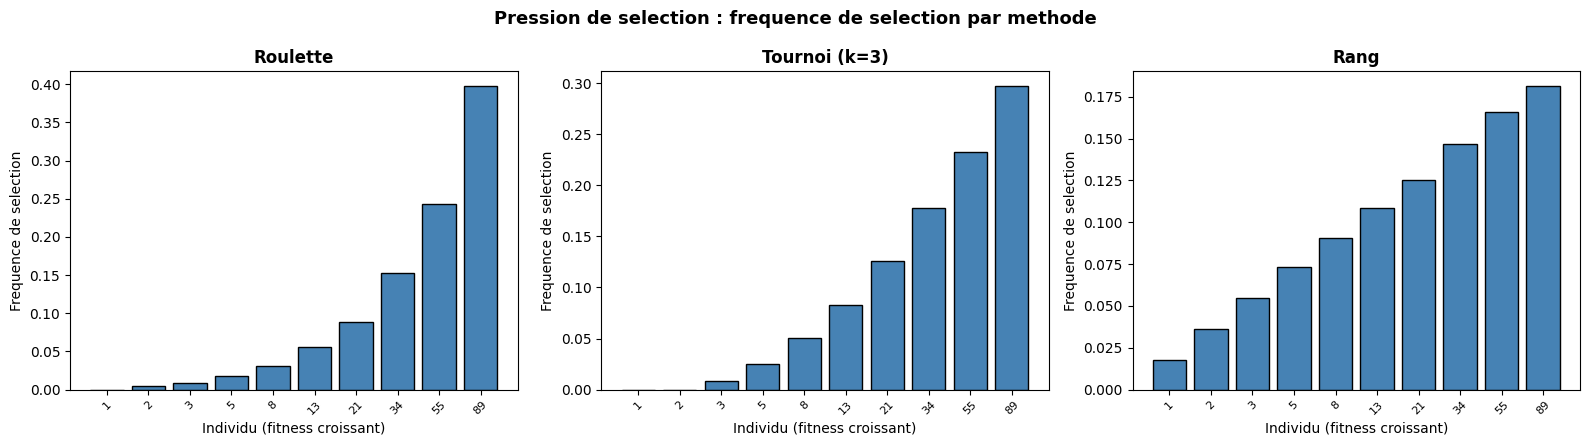

In [4]:
# Simuler la pression de selection
np.random.seed(SEED)
test_pop = list(range(10))  # 10 individus fictifs
test_fit = [1, 2, 3, 5, 8, 13, 21, 34, 55, 89]  # fitness croissants
n_trials = 10000
n_select_per_trial = 5

methods = {
    "Roulette": roulette_wheel_selection,
    "Tournoi (k=3)": lambda p, f, n: tournament_selection(p, f, n, tournament_size=3),
    "Rang": rank_selection,
}

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

for ax, (name, method) in zip(axes, methods.items()):
    counts = np.zeros(10)
    for _ in range(n_trials):
        selected = method(test_pop, test_fit, n_select_per_trial)
        for s in selected:
            counts[s] += 1
    
    # Normaliser en frequence
    freq = counts / counts.sum()
    bars = ax.bar(range(10), freq, color='steelblue', edgecolor='black')
    ax.set_xlabel('Individu (fitness croissant)')
    ax.set_ylabel('Frequence de selection')
    ax.set_title(name, fontweight='bold')
    ax.set_xticks(range(10))
    ax.set_xticklabels([str(f) for f in test_fit], rotation=45, fontsize=8)

plt.suptitle('Pression de selection : frequence de selection par methode',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### Interpretation : pression de selection

**Sortie obtenue** : les trois histogrammes montrent la frequence de selection de chaque individu (classe par fitness croissant).

| Methode | Pression | Comportement |
|---------|----------|--------------|
| **Roulette** | Elevee | L'individu 89 est selectionne ~38% du temps, les faibles (<5) sont quasi ignores |
| **Tournoi (k=3)** | Moderee a elevee | Distribution plus lissee, mais les meilleurs dominent |
| **Rang** | Moderee | La probabilite croit lineairement avec le rang, independamment des ecarts de fitness |

**Points cles** :
1. La **roulette** est tres sensible aux ecarts de fitness : un individu avec un fitness 10x superieur a 10x plus de chances
2. Le **tournoi** est le plus utilise en pratique : on controle la pression en ajustant la taille $k$ du tournoi
3. La **selection par rang** est robuste aux ecarts extremes de fitness (utile quand le fitness varie de plusieurs ordres de grandeur)

> **Regle pratique** : tournoi avec $k=3$ offre un bon equilibre entre exploration et exploitation.

### 2.3 Operateurs de crossover (croisement)

Le crossover combine le materiel genetique de deux parents pour creer un ou deux enfants. L'idee est de combiner les "bonnes parties" de solutions differentes.

Nous implementons quatre variantes :
- **Single-point** : un point de coupure
- **Two-point** : deux points de coupure
- **Uniform** : chaque gene est pris aleatoirement d'un parent
- **PMX** (Partially Mapped Crossover) : pour les encodages en permutation

In [5]:
def single_point_crossover(parent1, parent2):
    """Crossover a un point de coupure."""
    point = random.randint(1, len(parent1) - 1)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2


def two_point_crossover(parent1, parent2):
    """Crossover a deux points de coupure."""
    n = len(parent1)
    p1, p2 = sorted(random.sample(range(1, n), 2))
    child1 = parent1[:p1] + parent2[p1:p2] + parent1[p2:]
    child2 = parent2[:p1] + parent1[p1:p2] + parent2[p2:]
    return child1, child2


def uniform_crossover(parent1, parent2, p=0.5):
    """Crossover uniforme : chaque gene est pris d'un parent avec probabilite p."""
    child1 = []
    child2 = []
    for g1, g2 in zip(parent1, parent2):
        if random.random() < p:
            child1.append(g1)
            child2.append(g2)
        else:
            child1.append(g2)
            child2.append(g1)
    return child1, child2


def pmx_crossover(parent1, parent2):
    """Partially Mapped Crossover (PMX) pour les permutations.
    
    Preserve l'ordre relatif des elements, garantissant que
    les enfants sont aussi des permutations valides.
    """
    n = len(parent1)
    p1, p2 = sorted(random.sample(range(n), 2))
    
    child1 = [None] * n
    child2 = [None] * n
    
    # Copier le segment central
    child1[p1:p2] = parent2[p1:p2]
    child2[p1:p2] = parent1[p1:p2]
    
    # Mapping pour child1
    mapping1 = {parent2[i]: parent1[i] for i in range(p1, p2)}
    mapping2 = {parent1[i]: parent2[i] for i in range(p1, p2)}
    
    for i in list(range(0, p1)) + list(range(p2, n)):
        val = parent1[i]
        while val in child1[p1:p2]:
            val = mapping1[val]
        child1[i] = val
        
        val = parent2[i]
        while val in child2[p1:p2]:
            val = mapping2[val]
        child2[i] = val
    
    return child1, child2


print("Quatre operateurs de crossover definis.")

Quatre operateurs de crossover definis.


#### Visualisation des crossovers

Illustrons chaque crossover sur un exemple concret pour comprendre leur mecanisme.

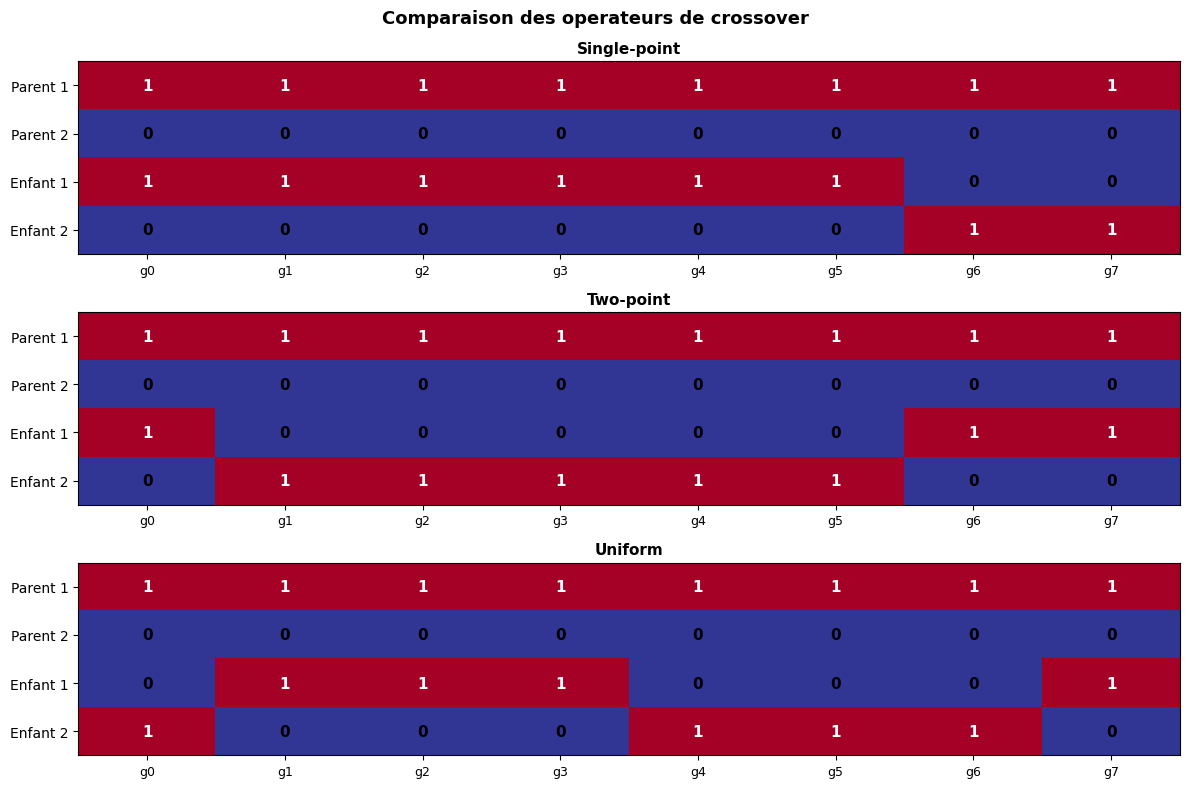

In [6]:
random.seed(42)

p1 = [1, 1, 1, 1, 1, 1, 1, 1]
p2 = [0, 0, 0, 0, 0, 0, 0, 0]

crossovers = [
    ("Single-point", single_point_crossover),
    ("Two-point", two_point_crossover),
    ("Uniform", uniform_crossover),
]

fig, axes = plt.subplots(len(crossovers), 1, figsize=(12, 8))

for ax, (name, cx_func) in zip(axes, crossovers):
    random.seed(42)
    c1, c2 = cx_func(p1, p2)
    
    # Afficher parent1, parent2, child1, child2 comme grilles colorees
    data = np.array([p1, p2, c1, c2])
    labels = ['Parent 1', 'Parent 2', 'Enfant 1', 'Enfant 2']
    
    cmap = plt.cm.RdYlBu_r
    ax.imshow(data, cmap=cmap, aspect='auto', vmin=0, vmax=1)
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            ax.text(j, i, str(data[i, j]), ha='center', va='center',
                    fontsize=11, fontweight='bold',
                    color='white' if data[i, j] == 1 else 'black')
    
    ax.set_yticks(range(4))
    ax.set_yticklabels(labels, fontsize=10)
    ax.set_xticks(range(8))
    ax.set_xticklabels([f'g{i}' for i in range(8)], fontsize=9)
    ax.set_title(name, fontweight='bold', fontsize=11)

plt.suptitle('Comparaison des operateurs de crossover',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### Interpretation : operateurs de crossover

**Sortie obtenue** : chaque operateur produit des enfants melangeant les genes des deux parents de maniere differente.

| Operateur | Mecanisme | Propriete |
|-----------|-----------|----------|
| **Single-point** | Un point de coupure, segments echanges | Preserve les blocs contigus (linkage) |
| **Two-point** | Deux points, segment central echange | Echange un sous-segment, plus de diversite |
| **Uniform** | Chaque gene independamment | Disruption maximale, bonne exploration |
| **PMX** | Pour permutations, mappings de positions | Preserve la validite des permutations |

**Points cles** :
1. Le choix du crossover depend de l'encodage et de la structure du probleme
2. Si les genes voisins interagissent (epistasie), le single-point preserve mieux ces interactions
3. Pour les permutations (TSP), il faut un crossover specifique (PMX, OX, CX) qui maintient la validite

### 2.4 Operateurs de mutation

La mutation introduit des variations aleatoires dans les chromosomes. Son role est de maintenir la **diversite genetique** et d'explorer des regions de l'espace que le crossover seul ne pourrait pas atteindre.

In [7]:
def bit_flip_mutation(chromosome, mutation_rate=0.01):
    """Mutation bit-flip pour encodage binaire.
    Chaque gene a une probabilite `mutation_rate` d'etre inverse."""
    mutated = chromosome.copy()
    for i in range(len(mutated)):
        if random.random() < mutation_rate:
            mutated[i] = 1 - mutated[i]
    return mutated


def swap_mutation(chromosome, mutation_rate=0.05):
    """Mutation par echange de deux positions (pour permutations)."""
    mutated = chromosome.copy()
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(mutated)), 2)
        mutated[i], mutated[j] = mutated[j], mutated[i]
    return mutated


def gaussian_mutation(chromosome, mutation_rate=0.1, sigma=0.5):
    """Mutation gaussienne pour encodage reel.
    Ajoute un bruit gaussien N(0, sigma) a chaque gene avec probabilite mutation_rate."""
    mutated = chromosome.copy()
    for i in range(len(mutated)):
        if random.random() < mutation_rate:
            mutated[i] += random.gauss(0, sigma)
    return mutated


# Demonstration de la mutation bit-flip
random.seed(42)
original = [1, 0, 1, 1, 0, 0, 1, 0, 1, 1]
mutated = bit_flip_mutation(original, mutation_rate=0.2)
print(f"Original : {original}")
print(f"Mute     : {mutated}")
print(f"Genes modifies : {sum(1 for a, b in zip(original, mutated) if a != b)}")

Original : [1, 0, 1, 1, 0, 0, 1, 0, 1, 1]
Mute     : [1, 1, 1, 1, 0, 0, 1, 1, 1, 0]
Genes modifies : 3


---

## 3. AG from scratch : le probleme OneMax (~10 min)

### Le probleme OneMax

Le probleme **OneMax** est le "Hello World" des algorithmes genetiques : trouver une chaine binaire de longueur $n$ qui maximise le nombre de 1.

- **Chromosome** : chaine binaire de longueur $n$
- **Fitness** : $f(x) = \sum_{i=1}^{n} x_i$ (nombre de 1)
- **Optimum** : $f^* = n$ (tous les genes a 1)

Ce probleme est simple mais pedagogique : il permet de valider une implementation et d'observer les dynamiques de convergence.

In [8]:
class SimpleGA:
    """Algorithme genetique simple pour le probleme OneMax.
    
    Parametres configurables : taille de population, taux de crossover,
    taux de mutation, methode de selection.
    """
    
    def __init__(self, chromosome_length, pop_size=50,
                 crossover_rate=0.8, mutation_rate=0.01,
                 selection_method='tournament', tournament_size=3,
                 elitism=True):
        self.chromosome_length = chromosome_length
        self.pop_size = pop_size
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.selection_method = selection_method
        self.tournament_size = tournament_size
        self.elitism = elitism
        
        # Historique pour analyse
        self.history_best = []
        self.history_avg = []
        self.history_worst = []
    
    def initialize_population(self):
        """Genere une population initiale aleatoire."""
        return [[random.randint(0, 1) for _ in range(self.chromosome_length)]
                for _ in range(self.pop_size)]
    
    def fitness(self, chromosome):
        """Fitness OneMax : nombre de 1 dans le chromosome."""
        return sum(chromosome)
    
    def select(self, population, fitnesses):
        """Selectionne les parents selon la methode configuree."""
        if self.selection_method == 'tournament':
            return tournament_selection(population, fitnesses,
                                       self.pop_size, self.tournament_size)
        elif self.selection_method == 'roulette':
            return roulette_wheel_selection(population, fitnesses, self.pop_size)
        elif self.selection_method == 'rank':
            return rank_selection(population, fitnesses, self.pop_size)
    
    def evolve(self, n_generations):
        """Execute l'AG pendant n_generations."""
        population = self.initialize_population()
        
        for gen in range(n_generations):
            # Evaluation
            fitnesses = [self.fitness(ind) for ind in population]
            
            # Enregistrer les statistiques
            self.history_best.append(max(fitnesses))
            self.history_avg.append(np.mean(fitnesses))
            self.history_worst.append(min(fitnesses))
            
            # Condition d'arret : optimum atteint
            if max(fitnesses) == self.chromosome_length:
                break
            
            # Elitisme : sauvegarder le meilleur
            best_idx = np.argmax(fitnesses)
            elite = population[best_idx].copy()
            
            # Selection
            parents = self.select(population, fitnesses)
            
            # Crossover et mutation
            new_population = []
            for i in range(0, len(parents) - 1, 2):
                p1, p2 = parents[i], parents[i + 1]
                
                if random.random() < self.crossover_rate:
                    c1, c2 = single_point_crossover(p1, p2)
                else:
                    c1, c2 = p1.copy(), p2.copy()
                
                c1 = bit_flip_mutation(c1, self.mutation_rate)
                c2 = bit_flip_mutation(c2, self.mutation_rate)
                
                new_population.extend([c1, c2])
            
            # Completer si population impaire
            while len(new_population) < self.pop_size:
                new_population.append(parents[-1].copy())
            
            # Appliquer l'elitisme
            if self.elitism:
                worst_idx = np.argmin([self.fitness(ind) for ind in new_population])
                new_population[worst_idx] = elite
            
            population = new_population[:self.pop_size]
        
        # Evaluation finale
        fitnesses = [self.fitness(ind) for ind in population]
        best_idx = np.argmax(fitnesses)
        return population[best_idx], fitnesses[best_idx]


print("Classe SimpleGA definie.")

Classe SimpleGA definie.


### Execution sur OneMax

Executons l'AG sur le probleme OneMax avec $n=50$ genes et observons la convergence.

In [9]:
# Executer l'AG sur OneMax (n=50)
random.seed(SEED)
np.random.seed(SEED)

ga = SimpleGA(
    chromosome_length=50,
    pop_size=100,
    crossover_rate=0.8,
    mutation_rate=0.02,
    selection_method='tournament',
    tournament_size=3,
    elitism=True
)

start = time.time()
best_ind, best_fit = ga.evolve(n_generations=200)
elapsed = (time.time() - start) * 1000

print(f"OneMax (n=50)")
print(f"={'=' * 45}")
print(f"Meilleur fitness     : {best_fit}/{ga.chromosome_length}")
print(f"Generations utilisees: {len(ga.history_best)}")
print(f"Temps                : {elapsed:.1f} ms")
print(f"Meilleur chromosome  : {''.join(map(str, best_ind))}")

OneMax (n=50)
Meilleur fitness     : 50/50
Generations utilisees: 22
Temps                : 15.6 ms
Meilleur chromosome  : 11111111111111111111111111111111111111111111111111


Tracons la courbe de convergence pour visualiser l'evolution du fitness au fil des generations.

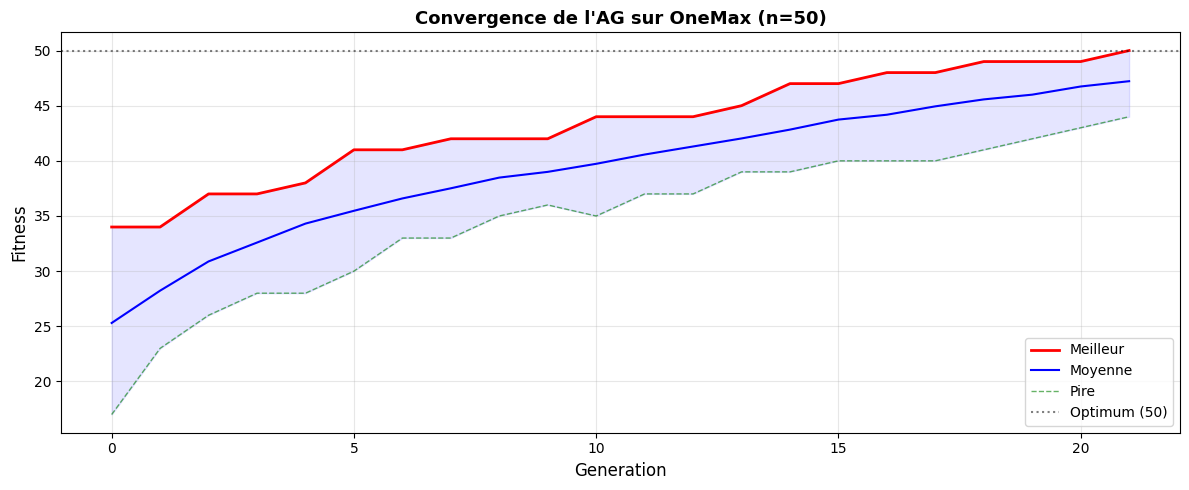

In [10]:
# Courbe de convergence
fig, ax = plt.subplots(figsize=(12, 5))

generations = range(len(ga.history_best))
ax.plot(generations, ga.history_best, 'r-', linewidth=2, label='Meilleur')
ax.plot(generations, ga.history_avg, 'b-', linewidth=1.5, label='Moyenne')
ax.plot(generations, ga.history_worst, 'g--', linewidth=1, alpha=0.6, label='Pire')
ax.fill_between(generations, ga.history_worst, ga.history_best, alpha=0.1, color='blue')

ax.axhline(y=50, color='black', linestyle=':', alpha=0.5, label='Optimum (50)')
ax.set_xlabel('Generation', fontsize=12)
ax.set_ylabel('Fitness', fontsize=12)
ax.set_title('Convergence de l\'AG sur OneMax (n=50)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Interpretation : convergence de l'AG sur OneMax

**Sortie obtenue** : la courbe montre l'evolution du fitness au fil des generations.

| Phase | Generations | Comportement |
|-------|-------------|---------------|
| **Exploration initiale** | 0-10 | Fitness moyen passe de ~25 a ~35, progres rapides |
| **Exploitation** | 10-40 | Progres ralentit, convergence vers l'optimum |
| **Stagnation** | 40+ | La population est homogene, seule la mutation apporte des changements |

**Points cles** :
1. L'ecart best-worst se reduit au fil des generations (la population converge)
2. L'**elitisme** garantit que le meilleur fitness ne diminue jamais
3. La mutation empeche la convergence prematuree en maintenant de la diversite

### Etude parametrique

Etudions l'impact de deux parametres critiques : la **taille de population** et le **taux de mutation**.

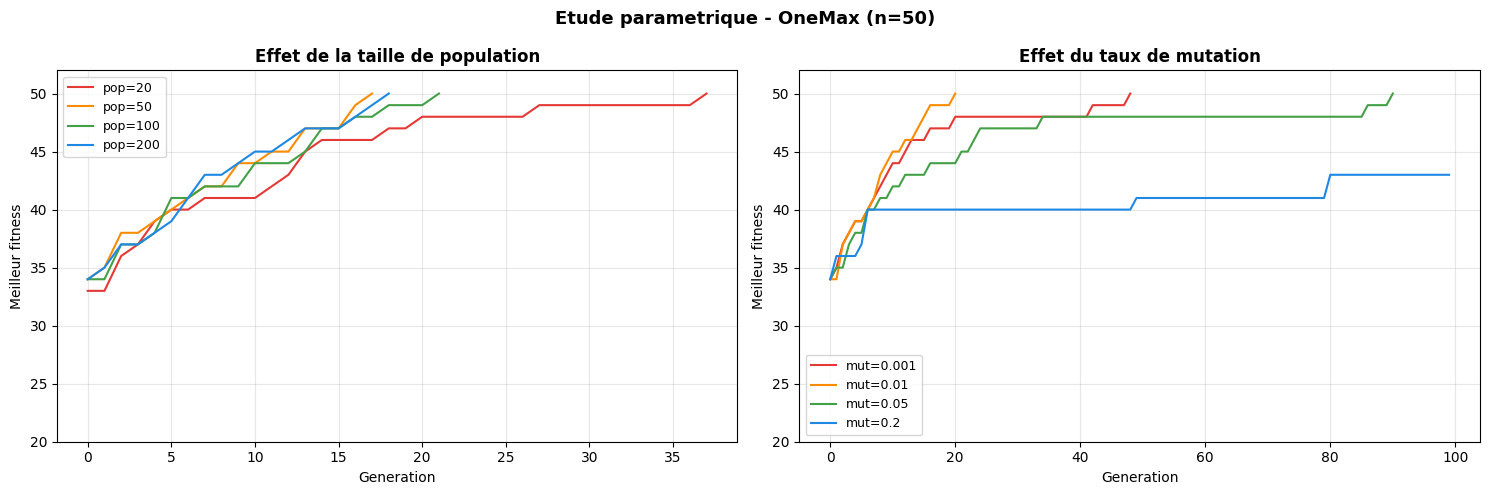

In [11]:
# Etude parametrique : population et mutation
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# --- Effet de la taille de population ---
pop_sizes = [20, 50, 100, 200]
colors_pop = ['#E53935', '#FB8C00', '#43A047', '#1E88E5']

for pop_size, color in zip(pop_sizes, colors_pop):
    random.seed(SEED)
    np.random.seed(SEED)
    ga_test = SimpleGA(chromosome_length=50, pop_size=pop_size,
                       mutation_rate=0.02, selection_method='tournament')
    ga_test.evolve(100)
    axes[0].plot(ga_test.history_best, color=color, linewidth=1.5,
                 label=f'pop={pop_size}')

axes[0].set_xlabel('Generation')
axes[0].set_ylabel('Meilleur fitness')
axes[0].set_title('Effet de la taille de population', fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(20, 52)

# --- Effet du taux de mutation ---
mut_rates = [0.001, 0.01, 0.05, 0.2]
colors_mut = ['#E53935', '#FB8C00', '#43A047', '#1E88E5']

for mut_rate, color in zip(mut_rates, colors_mut):
    random.seed(SEED)
    np.random.seed(SEED)
    ga_test = SimpleGA(chromosome_length=50, pop_size=100,
                       mutation_rate=mut_rate, selection_method='tournament')
    ga_test.evolve(100)
    axes[1].plot(ga_test.history_best, color=color, linewidth=1.5,
                 label=f'mut={mut_rate}')

axes[1].set_xlabel('Generation')
axes[1].set_ylabel('Meilleur fitness')
axes[1].set_title('Effet du taux de mutation', fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(20, 52)

plt.suptitle('Etude parametrique - OneMax (n=50)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### Interpretation : etude parametrique

**Sortie obtenue** : deux graphiques montrant l'impact de la taille de population et du taux de mutation.

| Parametre | Valeur faible | Valeur elevee |
|-----------|--------------|---------------|
| **Taille de population** | Convergence rapide mais risque de stagnation | Exploration plus large, convergence plus lente mais plus robuste |
| **Taux de mutation** | Diversite insuffisante, convergence prematuree | Trop de perturbation, "marche aleatoire" |

**Points cles** :
1. **Population** : une population trop petite (20) manque de diversite genetique ; trop grande (200) ralentit la convergence par generation
2. **Mutation** : le taux optimal est generalement entre 1/n et 5/n (ici 0.02-0.1 pour n=50)
3. Un taux de mutation de 0.2 est destructeur : il detruit les bonnes solutions plus vite qu'il n'en cree

> **Regle empirique** : taux de mutation $\approx 1/n$ ou $n$ est la longueur du chromosome.

---

## 4. Framework DEAP (~8 min)

### Introduction a DEAP

[DEAP](https://deap.readthedocs.io/) (Distributed Evolutionary Algorithms in Python) est le framework de reference pour les algorithmes evolutionnaires en Python. Il offre :

| Fonctionnalite | Description |
|---------------|-------------|
| `creator` | Definition de classes de fitness et d'individus |
| `base.Toolbox` | Enregistrement des operateurs genetiques |
| `tools` | Operateurs pre-implementes (selection, crossover, mutation) |
| `algorithms` | Algorithmes complets (eaSimple, eaMuPlusLambda, etc.) |
| `cma` | CMA-ES (Covariance Matrix Adaptation) |

DEAP est tres flexible mais sa syntaxe peut sembler deroutante au debut. Le principe est d'**enregistrer** les composants dans un `Toolbox`, puis de les combiner.

In [12]:
from deap import base, creator, tools, algorithms

# 1. Definir le type de fitness et d'individu
#    FitnessMax : on maximise (weights=(1.0,))
#    Individual : un individu est une liste avec un attribut fitness
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# 2. Configurer le Toolbox
toolbox = base.Toolbox()

# Attribut : un gene binaire (0 ou 1)
toolbox.register("attr_bool", random.randint, 0, 1)

# Individu : liste de 50 genes binaires
toolbox.register("individual", tools.initRepeat,
                 creator.Individual, toolbox.attr_bool, n=50)

# Population : liste d'individus
toolbox.register("population", tools.initRepeat,
                 list, toolbox.individual)

# 3. Fonction de fitness (OneMax)
def eval_onemax(individual):
    """Fitness OneMax : retourne un tuple (somme,)."""
    return (sum(individual),)  # DEAP attend un tuple

toolbox.register("evaluate", eval_onemax)

# 4. Operateurs genetiques
toolbox.register("mate", tools.cxTwoPoint)                # Crossover 2-points
toolbox.register("mutate", tools.mutFlipBit, indpb=0.02)  # Mutation bit-flip
toolbox.register("select", tools.selTournament, tournsize=3)  # Selection tournoi

print("DEAP configure pour OneMax.")
print(f"  Individu : {toolbox.individual()}")

DEAP configure pour OneMax.
  Individu : [1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]


### Execution avec eaSimple

`eaSimple` implemente un AG generationnel standard. Il prend la population, le toolbox et les parametres (taux de crossover, mutation, nombre de generations).

In [13]:
# Executer DEAP eaSimple
random.seed(SEED)

pop = toolbox.population(n=100)

# Statistiques a collecter
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("std", np.std)

# Hall of Fame : garder le meilleur individu de toute l'evolution
hof = tools.HallOfFame(1)

# Lancer l'evolution
start = time.time()
pop_final, logbook = algorithms.eaSimple(
    pop, toolbox,
    cxpb=0.8,      # probabilite de crossover
    mutpb=0.2,     # probabilite de mutation
    ngen=100,       # nombre de generations
    stats=stats,
    halloffame=hof,
    verbose=False
)
elapsed = (time.time() - start) * 1000

# Resultats
best = hof[0]
print(f"DEAP eaSimple - OneMax (n=50)")
print(f"={'=' * 45}")
print(f"Meilleur fitness : {best.fitness.values[0]:.0f}/50")
print(f"Temps            : {elapsed:.1f} ms")

DEAP eaSimple - OneMax (n=50)
Meilleur fitness : 50/50
Temps            : 298.8 ms


Visualisons la convergence de DEAP sur le meme probleme OneMax.

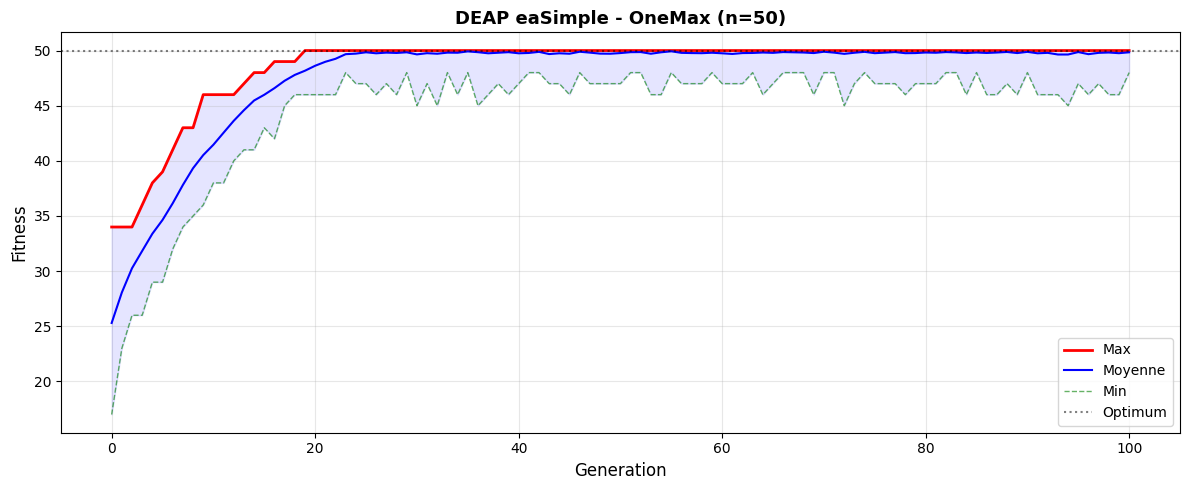

In [14]:
# Courbe de convergence DEAP
gen = logbook.select("gen")
avg = logbook.select("avg")
max_ = logbook.select("max")
min_ = logbook.select("min")

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(gen, max_, 'r-', linewidth=2, label='Max')
ax.plot(gen, avg, 'b-', linewidth=1.5, label='Moyenne')
ax.plot(gen, min_, 'g--', linewidth=1, alpha=0.6, label='Min')
ax.fill_between(gen, min_, max_, alpha=0.1, color='blue')
ax.axhline(y=50, color='black', linestyle=':', alpha=0.5, label='Optimum')

ax.set_xlabel('Generation', fontsize=12)
ax.set_ylabel('Fitness', fontsize=12)
ax.set_title('DEAP eaSimple - OneMax (n=50)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Interpretation : DEAP vs implementation from scratch

**Sortie obtenue** : DEAP produit une courbe de convergence similaire a notre implementation manuelle.

| Aspect | From scratch | DEAP |
|--------|-------------|------|
| **Lignes de code** | ~80 lignes | ~20 lignes |
| **Flexibilite** | Controle total | Operateurs interchangeables |
| **Statistiques** | Manuelles | Automatiques via `Statistics` |
| **Hall of Fame** | Manuelle | Integree |
| **Parallelisme** | Non | Support multiprocessing |

**Points cles** :
1. DEAP simplifie considerablement le code tout en offrant plus de fonctionnalites
2. Le `Logbook` collecte automatiquement les statistiques generation par generation
3. Le `HallOfFame` garde les meilleurs individus, equivalent a l'elitisme

> **Recommandation** : utiliser DEAP pour tout projet serieux. Notre implementation from scratch est pedagogique, DEAP est pour la production.

---

## 5. Framework PyGAD : optimisation continue (~8 min)

### PyGAD vs DEAP

[PyGAD](https://pygad.readthedocs.io/) est une bibliotheque plus simple que DEAP, orientee vers le prototypage rapide. Elle est particulierement adaptee aux problemes d'optimisation continue.

| Critere | DEAP | PyGAD |
|---------|------|-------|
| Flexibilite | Tres elevee | Moderee |
| Courbe d'apprentissage | Raide | Douce |
| Operateurs | Tres nombreux | Essentiels |
| Multi-objectif | NSGA-II, SPEA2 | Non |
| Cas d'usage | Recherche, projets complexes | Prototypage, cours, TP |

### La fonction de Rastrigin

Nous allons optimiser la **fonction de Rastrigin**, un benchmark classique :

$$f(\mathbf{x}) = 10n + \sum_{i=1}^{n} \left[ x_i^2 - 10 \cos(2\pi x_i) \right]$$

- **Minimum global** : $f(\mathbf{0}) = 0$
- **Difficulte** : de tres nombreux minima locaux (paysage "hérissé")
- **Domaine** : $x_i \in [-5.12, 5.12]$

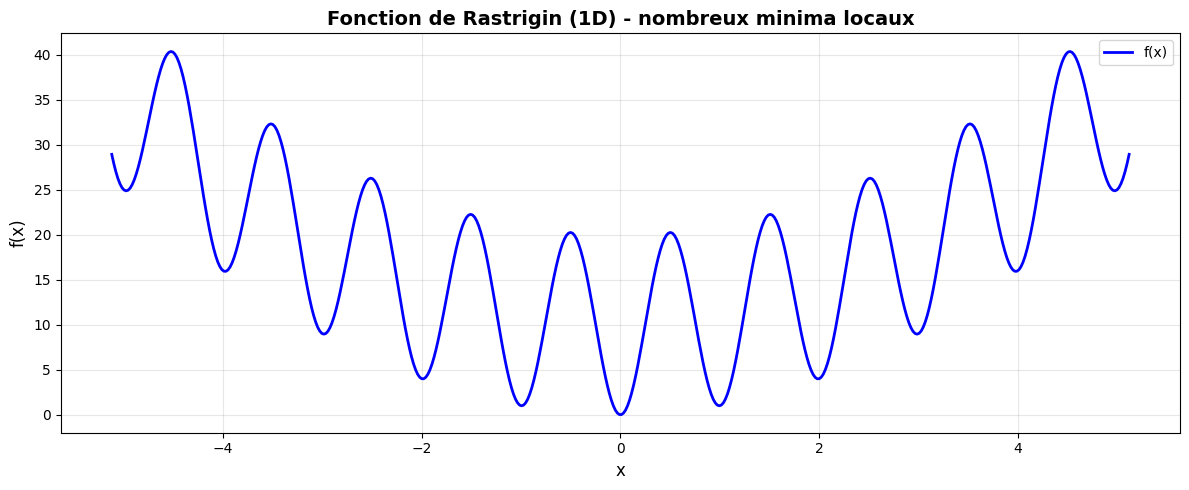

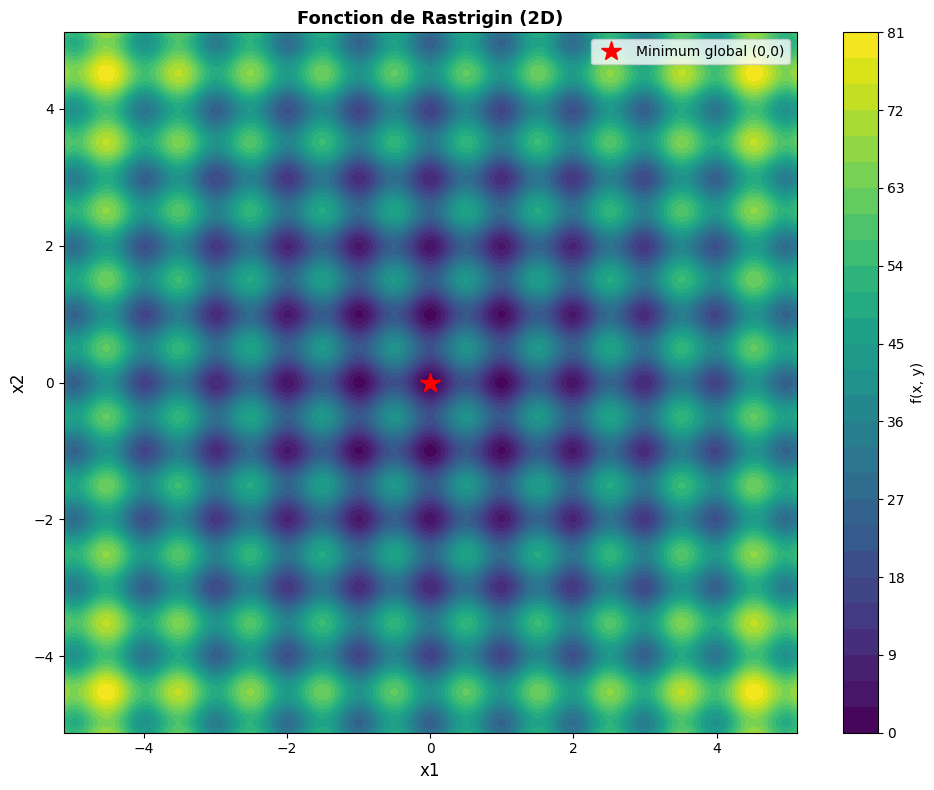

In [15]:
def rastrigin(x):
    """Fonction de Rastrigin (a minimiser)."""
    n = len(x)
    return 10 * n + sum(xi**2 - 10 * np.cos(2 * np.pi * xi) for xi in x)


# Visualisation 1D
draw_fitness_landscape(
    lambda x: 10 + x**2 - 10 * np.cos(2 * np.pi * x),
    x_range=(-5.12, 5.12),
    title='Fonction de Rastrigin (1D) - nombreux minima locaux'
)
plt.show()

# Visualisation 2D (surface)
x = np.linspace(-5.12, 5.12, 200)
y = np.linspace(-5.12, 5.12, 200)
X, Y = np.meshgrid(x, y)
Z = 20 + X**2 - 10 * np.cos(2 * np.pi * X) + Y**2 - 10 * np.cos(2 * np.pi * Y)

fig, ax = plt.subplots(figsize=(10, 8))
contour = ax.contourf(X, Y, Z, levels=30, cmap='viridis')
plt.colorbar(contour, ax=ax, label='f(x, y)')
ax.plot(0, 0, 'r*', markersize=15, label='Minimum global (0,0)')
ax.set_xlabel('x1', fontsize=12)
ax.set_ylabel('x2', fontsize=12)
ax.set_title('Fonction de Rastrigin (2D)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

### Interpretation : paysage de Rastrigin

**Sortie obtenue** : la fonction de Rastrigin presente un paysage extremement multimodal.

| Propriete | Valeur |
|-----------|--------|
| Minimum global | $f(0, 0) = 0$ |
| Nombre de minima locaux | $\approx 10^n$ pour $n$ dimensions |
| Espacement des minima | Regulier (~1 unite) |
| Profondeur des puits | Similaire |

**Points cles** :
1. Les methodes de recherche locale (Hill Climbing, Recuit Simule) risquent de rester pieges dans un minimum local
2. L'AG explore simultanement plusieurs regions grace a sa population
3. Le crossover peut combiner des solutions proches de differents minima pour "sauter" vers le minimum global

In [16]:
import pygad

# Fonction de fitness pour PyGAD (maximisation, donc on inverse Rastrigin)
def fitness_func_rastrigin(ga_instance, solution, solution_idx):
    """Fitness = -Rastrigin (car PyGAD maximise)."""
    return -rastrigin(solution)


# Collecter l'historique des fitness
pygad_history = []

def on_generation_pygad(ga_instance):
    best_solution, best_fitness, _ = ga_instance.best_solution()
    pygad_history.append(-best_fitness)  # Re-inverser pour avoir Rastrigin


# Configurer PyGAD
ga_pygad = pygad.GA(
    num_generations=200,
    num_parents_mating=20,
    fitness_func=fitness_func_rastrigin,
    sol_per_pop=100,
    num_genes=5,               # 5 dimensions
    init_range_low=-5.12,
    init_range_high=5.12,
    gene_space={'low': -5.12, 'high': 5.12},
    parent_selection_type='tournament',
    K_tournament=3,
    crossover_type='two_points',
    mutation_type='random',
    mutation_percent_genes=20,
    on_generation=on_generation_pygad,
    random_seed=SEED,
    suppress_warnings=True
)

# Executer
start = time.time()
ga_pygad.run()
elapsed_pygad = (time.time() - start) * 1000

best_solution, best_fitness, _ = ga_pygad.best_solution()

print(f"PyGAD - Rastrigin (5D)")
print(f"={'=' * 45}")
print(f"Meilleur f(x)    : {-best_fitness:.6f}")
print(f"Optimum theorique: 0.000000")
print(f"Solution         : {np.round(best_solution, 4)}")
print(f"Temps            : {elapsed_pygad:.1f} ms")

PyGAD - Rastrigin (5D)
Meilleur f(x)    : 0.521545
Optimum theorique: 0.000000
Solution         : [ 0.0437  0.0174 -0.0114  0.0041 -0.0169]
Temps            : 720.2 ms


Tracons la convergence de PyGAD en echelle logarithmique pour mieux voir la progression vers l'optimum.

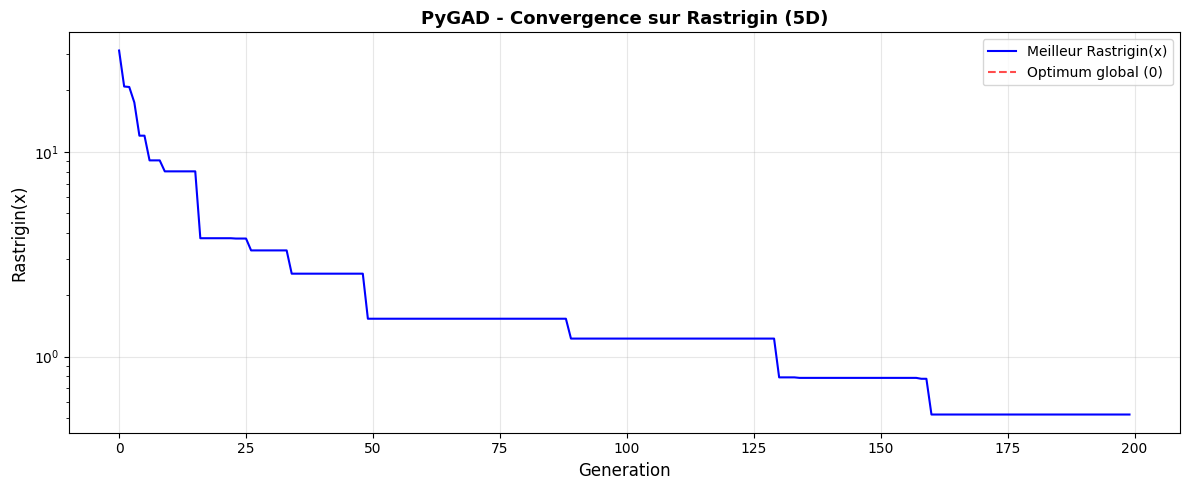

In [17]:
# Courbe de convergence PyGAD
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(pygad_history, 'b-', linewidth=1.5, label='Meilleur Rastrigin(x)')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Optimum global (0)')
ax.set_xlabel('Generation', fontsize=12)
ax.set_ylabel('Rastrigin(x)', fontsize=12)
ax.set_title('PyGAD - Convergence sur Rastrigin (5D)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
plt.tight_layout()
plt.show()

### Interpretation : PyGAD sur Rastrigin

**Sortie obtenue** : PyGAD converge vers le minimum global de la fonction de Rastrigin.

| Mesure | Valeur |
|--------|--------|
| Minimum trouve | proche de 0 |
| Solution | proche de (0, 0, 0, 0, 0) |
| Convergence | Echelle log montre une decroissance exponentielle initiale |

**Comparaison DEAP vs PyGAD** :

| Critere | DEAP | PyGAD |
|---------|------|-------|
| Configuration | Verbose mais flexible | Compact (un seul constructeur) |
| Operateurs | Registre via Toolbox | Parametres du constructeur |
| Logging | Logbook + Statistics | Callback on_generation |
| Quand l'utiliser | Algorithmes sur mesure, multi-objectif | Prototypage rapide, problemes standards |

---

## 6. Concepts avances (~6 min)

### 6.1 Elitisme

L'**elitisme** consiste a copier directement les $k$ meilleurs individus d'une generation a la suivante, sans les soumettre au crossover ni a la mutation.

| Sans elitisme | Avec elitisme |
|--------------|---------------|
| Le meilleur fitness peut diminuer | Le meilleur fitness est monotone croissant |
| Plus de diversite | Risque de convergence prematuree si k est trop grand |
| Exploration | Exploitation |

En pratique, on garde $k=1$ ou $k=2$ elites. C'est ce que fait le `HallOfFame` de DEAP.

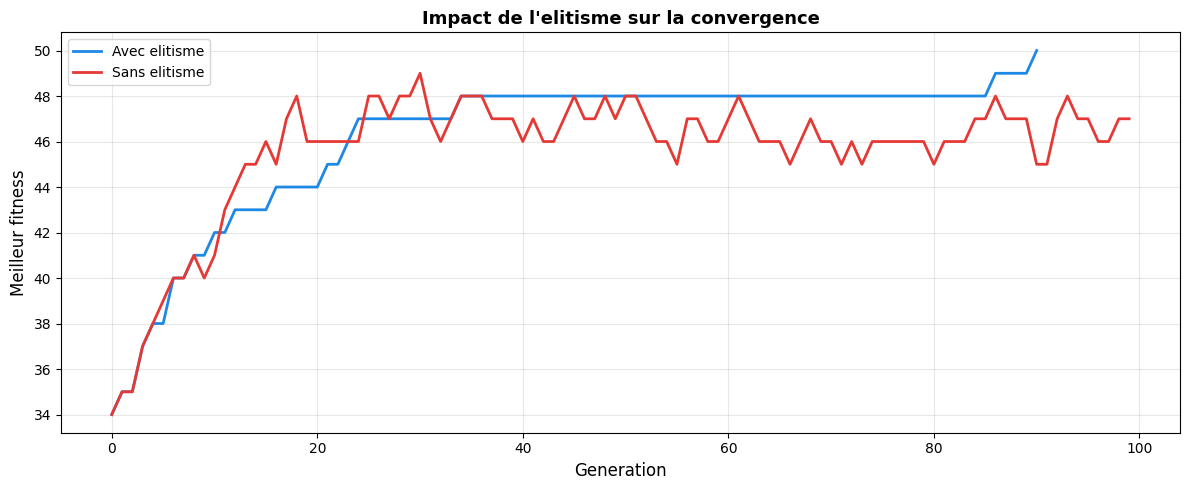

In [18]:
# Comparaison avec et sans elitisme
fig, ax = plt.subplots(figsize=(12, 5))

for elitism, color, label in [(True, '#1E88E5', 'Avec elitisme'),
                               (False, '#E53935', 'Sans elitisme')]:
    random.seed(SEED)
    np.random.seed(SEED)
    ga_test = SimpleGA(chromosome_length=50, pop_size=100,
                       mutation_rate=0.05, elitism=elitism)
    ga_test.evolve(100)
    ax.plot(ga_test.history_best, color=color, linewidth=2, label=label)

ax.set_xlabel('Generation', fontsize=12)
ax.set_ylabel('Meilleur fitness', fontsize=12)
ax.set_title('Impact de l\'elitisme sur la convergence', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Interpretation : elitisme

**Sortie obtenue** : la courbe avec elitisme est monotone croissante, celle sans elitisme peut presenter des "reculs".

**Points cles** :
1. L'elitisme garantit que la qualite de la meilleure solution ne diminue jamais
2. Sans elitisme, un taux de mutation eleve (0.05) peut degrader de bonnes solutions
3. En pratique, l'elitisme est quasi toujours active ($k = 1$)

### 6.2 Taux de mutation adaptatif

Plutot que d'utiliser un taux fixe, on peut adapter le taux de mutation au fil des generations :

$$\text{mutation\_rate}(t) = \text{rate}_{max} \cdot \left(1 - \frac{t}{T}\right) + \text{rate}_{min}$$

- **Debut** : taux eleve pour explorer largement
- **Fin** : taux faible pour affiner autour des bonnes solutions

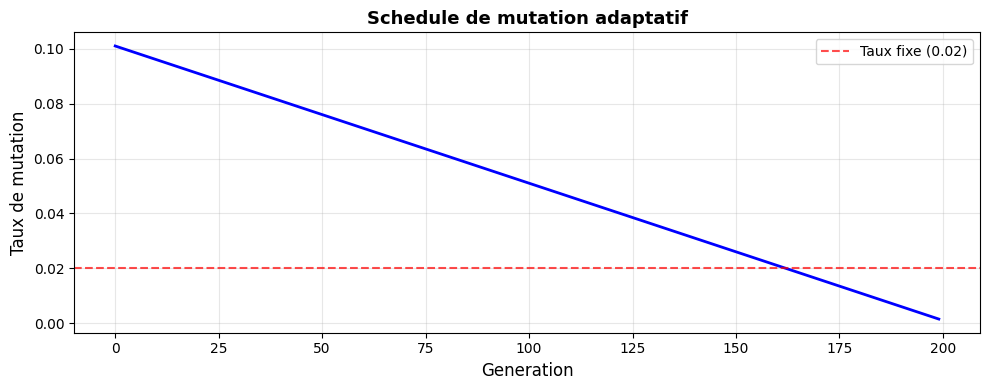

In [19]:
def adaptive_mutation_rate(generation, max_gen, rate_max=0.1, rate_min=0.001):
    """Taux de mutation decroissant lineairement."""
    return rate_max * (1 - generation / max_gen) + rate_min


# Visualisation du schedule
gens = np.arange(200)
rates = [adaptive_mutation_rate(g, 200) for g in gens]

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(gens, rates, 'b-', linewidth=2)
ax.set_xlabel('Generation', fontsize=12)
ax.set_ylabel('Taux de mutation', fontsize=12)
ax.set_title('Schedule de mutation adaptatif', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=0.02, color='red', linestyle='--', alpha=0.7, label='Taux fixe (0.02)')
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

### 6.3 Apercu des extensions

Les algorithmes genetiques se declinent en de nombreuses variantes avancees :

| Extension | Principe | Cas d'usage |
|-----------|----------|-------------|
| **NSGA-II** | Optimisation multi-objectif avec front de Pareto | Compromis cout/performance |
| **Island Model** | Populations paralleles avec migrations periodiques | Maintien de la diversite |
| **Memetic Algorithms** | AG + recherche locale pour affiner chaque individu | Combinatoire complexe |
| **CMA-ES** | Adaptation de la matrice de covariance | Optimisation continue |
| **Genetic Programming** | Les chromosomes sont des programmes/arbres | Regression symbolique |

### Lien avec les Applications

Les algorithmes genetiques sont appliques dans la suite de cette serie :
- **App-9 (Edge Detection)** : GA pour optimiser un filtre de convolution de detection de bords (voir [PyGad-EdgeDetection](../PyGad-EdgeDetection.ipynb))
- **App-10 (Portfolio)** : GA pour l'optimisation de portefeuille financier (voir [Portfolio_Optimization_GeneticSharp](../Portfolio_Optimization_GeneticSharp.ipynb))

Ces applications montrent la puissance des AG sur des problemes reels ou la fonction objectif est complexe et l'espace de recherche est vaste.

---

## 7. Resume et exercices

### Tableau recapitulatif des composants

| Composant | Options | Recommandation |
|-----------|---------|----------------|
| **Encodage** | Binaire, entier, reel, permutation | Adapter au probleme |
| **Selection** | Roulette, tournoi, rang | Tournoi ($k=3$) par defaut |
| **Crossover** | 1-point, 2-points, uniforme, PMX | 2-points ou uniforme |
| **Mutation** | Bit-flip, swap, gaussienne | Taux $\approx 1/n$ |
| **Elitisme** | $k = 1$ ou $2$ | Toujours activer |

### Comparaison des methodes de selection

| Methode | Pression | Preservation diversite | Sensibilite aux ecarts |
|---------|----------|----------------------|------------------------|
| **Roulette** | Variable (depend des fitness) | Faible | Tres elevee |
| **Tournoi** | Controlable via $k$ | Moderee | Faible |
| **Rang** | Fixe (lineaire) | Elevee | Nulle |

### AG vs Recherche locale

| Critere | Recherche locale (Search-4) | Algorithme genetique |
|---------|---------------------------|---------------------|
| Nombre de solutions | 1 | Population entiere |
| Evasion optima locaux | Temperature (SA), memoire (Tabou) | Crossover + diversite |
| Parallelisme | Difficile | Naturel |
| Parametres | Peu (temperature, voisinage) | Nombreux (pop, mutation, crossover, selection) |
| Cout par iteration | Faible | Eleve ($\times$ taille population) |

### Exercice 1 : TSP avec encodage en permutation

**Enonce** : resolvez un petit probleme du voyageur de commerce (TSP) avec 8 villes en utilisant un AG avec encodage en permutation.

- Encodage : permutation des indices de villes
- Crossover : PMX
- Mutation : swap de deux villes
- Fitness : distance totale du circuit (a minimiser)

In [20]:
# Exercice 1 : TSP avec AG

# Coordonnees de 8 villes
cities = np.array([
    [0, 0], [1, 5], [5, 2], [7, 8],
    [8, 1], [3, 6], [6, 5], [2, 3]
])
n_cities = len(cities)

def tsp_distance(route):
    """Distance totale d'un circuit TSP."""
    total = 0
    for i in range(len(route)):
        c1 = cities[route[i]]
        c2 = cities[route[(i + 1) % len(route)]]
        total += np.sqrt((c1[0] - c2[0])**2 + (c1[1] - c2[1])**2)
    return total


def ga_tsp(n_cities, pop_size=100, n_generations=300, mutation_rate=0.3):
    """AG pour TSP avec PMX crossover et swap mutation."""
    # Population initiale : permutations aleatoires
    population = [list(np.random.permutation(n_cities)) for _ in range(pop_size)]
    
    best_history = []
    avg_history = []
    best_ever = None
    best_ever_fitness = float('inf')
    
    for gen in range(n_generations):
        # Evaluation (distance = a minimiser, fitness = -distance)
        distances = [tsp_distance(ind) for ind in population]
        fitnesses = [-d for d in distances]  # Maximiser le negatif de la distance
        
        best_gen = min(distances)
        best_history.append(best_gen)
        avg_history.append(np.mean(distances))
        
        if best_gen < best_ever_fitness:
            best_ever_fitness = best_gen
            best_idx = np.argmin(distances)
            best_ever = population[best_idx].copy()
        
        # Selection par tournoi
        parents = tournament_selection(population, fitnesses, pop_size, tournament_size=3)
        
        # Crossover PMX + mutation swap
        new_pop = []
        for i in range(0, len(parents) - 1, 2):
            if random.random() < 0.8:
                c1, c2 = pmx_crossover(parents[i], parents[i+1])
            else:
                c1, c2 = parents[i].copy(), parents[i+1].copy()
            
            c1 = swap_mutation(c1, mutation_rate)
            c2 = swap_mutation(c2, mutation_rate)
            new_pop.extend([c1, c2])
        
        # Elitisme
        new_pop[0] = best_ever.copy()
        population = new_pop[:pop_size]
    
    return best_ever, best_ever_fitness, best_history, avg_history


# Executer
random.seed(SEED)
np.random.seed(SEED)

best_route, best_distance, hist_best, hist_avg = ga_tsp(
    n_cities, pop_size=100, n_generations=300, mutation_rate=0.3
)

print(f"TSP ({n_cities} villes) - Algorithme Genetique")
print(f"={'=' * 45}")
print(f"Meilleure route   : {best_route}")
print(f"Distance totale   : {best_distance:.2f}")

TSP (8 villes) - Algorithme Genetique
Meilleure route   : [np.int32(1), np.int32(7), np.int32(0), np.int32(2), np.int32(4), np.int32(6), np.int32(3), np.int32(5)]
Distance totale   : 28.73


Visualisons la meilleure route trouvee et la courbe de convergence.

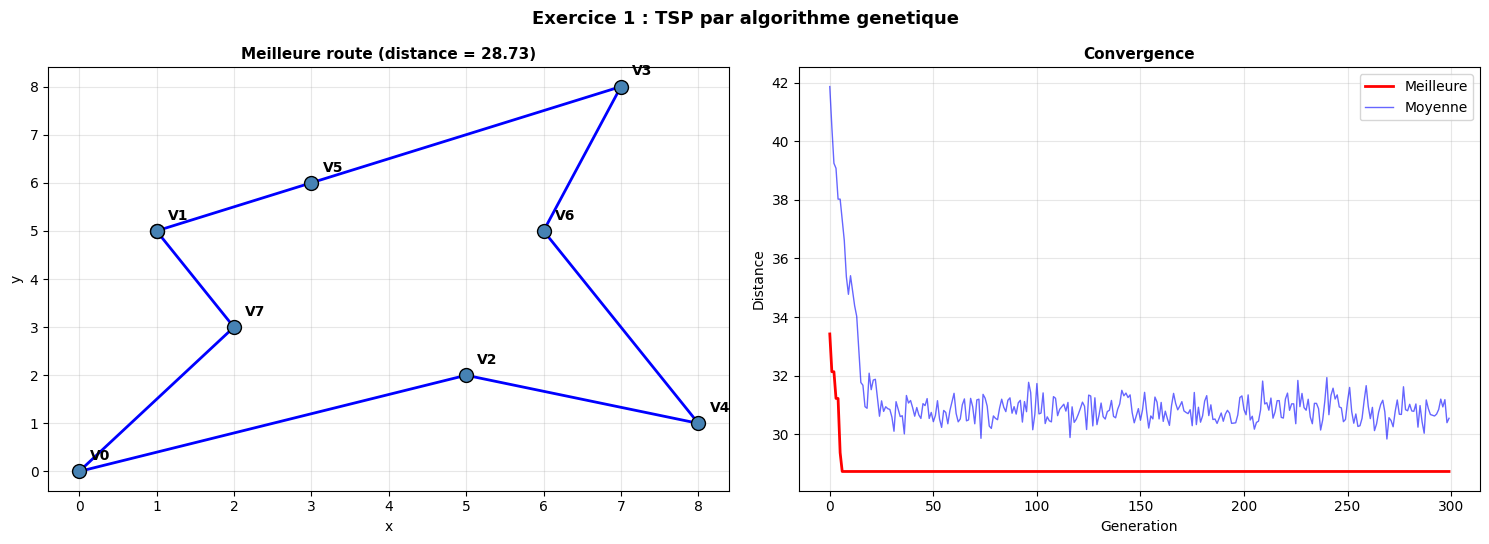

In [21]:
# Visualisation de la solution TSP
fig, axes = plt.subplots(1, 2, figsize=(15, 5.5))

# --- Route ---
ax = axes[0]
route = best_route + [best_route[0]]  # Boucler
route_coords = cities[route]

ax.plot(route_coords[:, 0], route_coords[:, 1], 'b-o', linewidth=2,
        markersize=10, markerfacecolor='steelblue', markeredgecolor='black')
for i, (x, y) in enumerate(cities):
    ax.annotate(f'V{i}', (x, y), textcoords='offset points',
                xytext=(8, 8), fontsize=10, fontweight='bold')
ax.set_title(f'Meilleure route (distance = {best_distance:.2f})',
             fontweight='bold', fontsize=11)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid(True, alpha=0.3)

# --- Convergence ---
ax = axes[1]
ax.plot(hist_best, 'r-', linewidth=2, label='Meilleure')
ax.plot(hist_avg, 'b-', linewidth=1, alpha=0.6, label='Moyenne')
ax.set_xlabel('Generation')
ax.set_ylabel('Distance')
ax.set_title('Convergence', fontweight='bold', fontsize=11)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.suptitle('Exercice 1 : TSP par algorithme genetique',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### Interpretation : TSP par AG

**Sortie obtenue** : l'AG trouve une route raisonnable pour 8 villes.

| Observation | Detail |
|-------------|--------|
| Convergence | Rapide au debut, puis plateau |
| Route | Visuellement coherente (pas de croisements majeurs) |
| PMX | Preserve les sous-sequences de villes, adaptee au TSP |

**Points cles** :
1. L'encodage en **permutation** garantit que chaque ville est visitee exactement une fois
2. Le **PMX crossover** est essentiel : un crossover classique (1-point) produirait des permutations invalides
3. La **swap mutation** est l'equivalent de la mutation bit-flip pour les permutations

### Exercice 2 : comparaison des operateurs de crossover

**Enonce** : comparez les trois operateurs de crossover (single-point, two-point, uniform) sur le probleme OneMax (n=100) en termes de vitesse de convergence.

Pour chaque operateur, executez l'AG 5 fois et tracez la courbe de convergence moyenne.

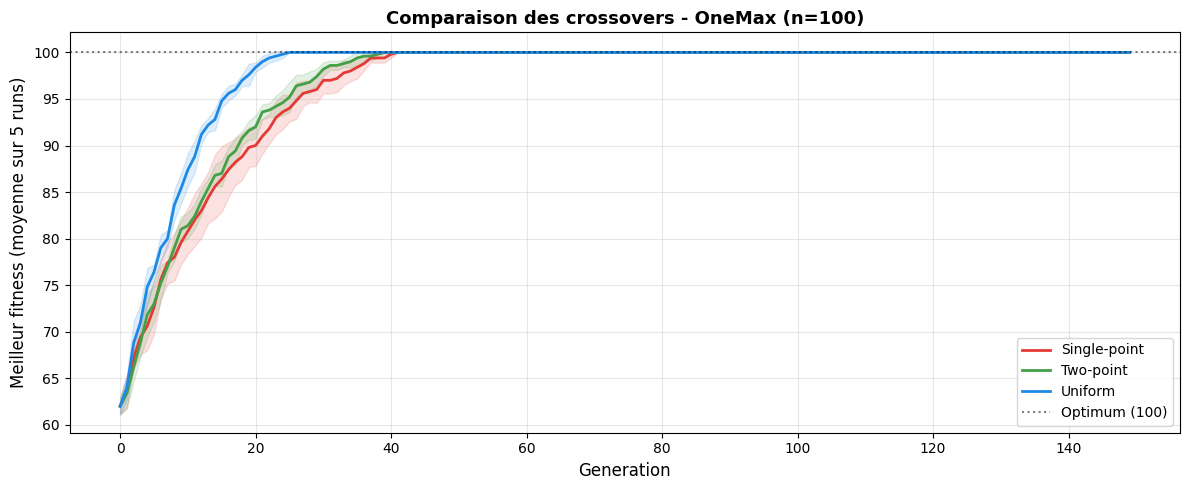

In [22]:
# Exercice 2 : comparaison des crossovers

class GA_CustomCrossover(SimpleGA):
    """GA avec crossover configurable."""
    
    def __init__(self, crossover_func, **kwargs):
        super().__init__(**kwargs)
        self.crossover_func = crossover_func
    
    def evolve(self, n_generations):
        population = self.initialize_population()
        
        for gen in range(n_generations):
            fitnesses = [self.fitness(ind) for ind in population]
            self.history_best.append(max(fitnesses))
            self.history_avg.append(np.mean(fitnesses))
            
            if max(fitnesses) == self.chromosome_length:
                # Completer l'historique
                for _ in range(n_generations - gen - 1):
                    self.history_best.append(self.chromosome_length)
                    self.history_avg.append(np.mean(fitnesses))
                break
            
            best_idx = np.argmax(fitnesses)
            elite = population[best_idx].copy()
            
            parents = self.select(population, fitnesses)
            new_population = []
            for i in range(0, len(parents) - 1, 2):
                p1, p2 = parents[i], parents[i + 1]
                if random.random() < self.crossover_rate:
                    c1, c2 = self.crossover_func(p1, p2)
                else:
                    c1, c2 = p1.copy(), p2.copy()
                c1 = bit_flip_mutation(c1, self.mutation_rate)
                c2 = bit_flip_mutation(c2, self.mutation_rate)
                new_population.extend([c1, c2])
            
            while len(new_population) < self.pop_size:
                new_population.append(parents[-1].copy())
            
            worst_idx = np.argmin([self.fitness(ind) for ind in new_population])
            new_population[worst_idx] = elite
            population = new_population[:self.pop_size]
        
        fitnesses = [self.fitness(ind) for ind in population]
        best_idx = np.argmax(fitnesses)
        return population[best_idx], fitnesses[best_idx]


# Comparer les 3 crossovers
crossover_ops = [
    ('Single-point', single_point_crossover),
    ('Two-point', two_point_crossover),
    ('Uniform', uniform_crossover),
]

n_runs = 5
n_gen = 150
n_genes = 100

fig, ax = plt.subplots(figsize=(12, 5))
colors = ['#E53935', '#43A047', '#1E88E5']

for (name, cx_func), color in zip(crossover_ops, colors):
    all_best = []
    for run in range(n_runs):
        random.seed(SEED + run)
        np.random.seed(SEED + run)
        ga_cx = GA_CustomCrossover(
            crossover_func=cx_func,
            chromosome_length=n_genes,
            pop_size=100,
            mutation_rate=0.01
        )
        ga_cx.evolve(n_gen)
        all_best.append(ga_cx.history_best[:n_gen])
    
    # Moyenne et ecart-type
    mean_best = np.mean(all_best, axis=0)
    std_best = np.std(all_best, axis=0)
    
    ax.plot(mean_best, color=color, linewidth=2, label=name)
    ax.fill_between(range(n_gen), mean_best - std_best, mean_best + std_best,
                    color=color, alpha=0.15)

ax.axhline(y=n_genes, color='black', linestyle=':', alpha=0.5, label=f'Optimum ({n_genes})')
ax.set_xlabel('Generation', fontsize=12)
ax.set_ylabel('Meilleur fitness (moyenne sur 5 runs)', fontsize=12)
ax.set_title(f'Comparaison des crossovers - OneMax (n={n_genes})',
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Interpretation : comparaison des crossovers

**Sortie obtenue** : les trois operateurs convergent mais a des vitesses differentes.

| Crossover | Vitesse de convergence | Diversite |
|-----------|----------------------|----------|
| **Single-point** | Moderee | Preserve les blocs |
| **Two-point** | Bonne | Compromis |
| **Uniform** | La plus rapide | Disruption maximale |

**Analyse** : pour OneMax (genes independants), le crossover **uniforme** est optimal car il melange maximalement les genes. Pour des problemes ou les genes voisins interagissent (epistasie), le single-point serait preferable.

### Exercice 3 : mutation adaptative

**Enonce** : implementez et testez un AG avec un taux de mutation adaptatif (decroissant au fil des generations). Comparez avec un taux fixe sur le probleme OneMax (n=100).

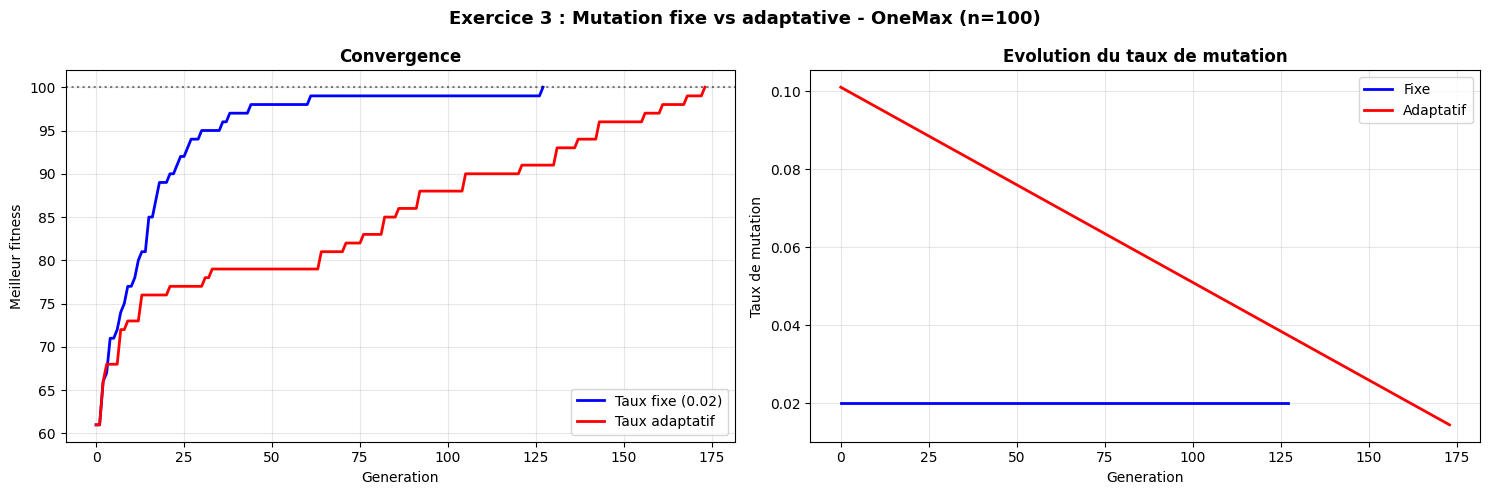


Resultats :
  Taux fixe    : meilleur = 100/100 en 128 generations
  Adaptatif    : meilleur = 100/100 en 174 generations


In [23]:
# Exercice 3 : mutation adaptative

class GA_AdaptiveMutation(SimpleGA):
    """AG avec taux de mutation decroissant."""
    
    def __init__(self, rate_max=0.1, rate_min=0.001, **kwargs):
        super().__init__(**kwargs)
        self.rate_max = rate_max
        self.rate_min = rate_min
    
    def evolve(self, n_generations):
        population = self.initialize_population()
        self.mutation_rates_used = []
        
        for gen in range(n_generations):
            # Taux adaptatif
            current_rate = adaptive_mutation_rate(
                gen, n_generations, self.rate_max, self.rate_min
            )
            self.mutation_rates_used.append(current_rate)
            
            fitnesses = [self.fitness(ind) for ind in population]
            self.history_best.append(max(fitnesses))
            self.history_avg.append(np.mean(fitnesses))
            
            if max(fitnesses) == self.chromosome_length:
                break
            
            best_idx = np.argmax(fitnesses)
            elite = population[best_idx].copy()
            
            parents = self.select(population, fitnesses)
            new_population = []
            for i in range(0, len(parents) - 1, 2):
                p1, p2 = parents[i], parents[i + 1]
                if random.random() < self.crossover_rate:
                    c1, c2 = single_point_crossover(p1, p2)
                else:
                    c1, c2 = p1.copy(), p2.copy()
                c1 = bit_flip_mutation(c1, current_rate)
                c2 = bit_flip_mutation(c2, current_rate)
                new_population.extend([c1, c2])
            
            while len(new_population) < self.pop_size:
                new_population.append(parents[-1].copy())
            
            worst_idx = np.argmin([self.fitness(ind) for ind in new_population])
            new_population[worst_idx] = elite
            population = new_population[:self.pop_size]
        
        fitnesses = [self.fitness(ind) for ind in population]
        best_idx = np.argmax(fitnesses)
        return population[best_idx], fitnesses[best_idx]


# Comparaison : fixe vs adaptatif
n_gen = 200
n_genes = 100

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# --- AG avec taux fixe ---
random.seed(SEED)
np.random.seed(SEED)
ga_fixed = SimpleGA(chromosome_length=n_genes, pop_size=100,
                    mutation_rate=0.02)
ga_fixed.evolve(n_gen)

# --- AG avec taux adaptatif ---
random.seed(SEED)
np.random.seed(SEED)
ga_adaptive = GA_AdaptiveMutation(
    rate_max=0.1, rate_min=0.001,
    chromosome_length=n_genes, pop_size=100
)
ga_adaptive.evolve(n_gen)

# Convergence
axes[0].plot(ga_fixed.history_best, 'b-', linewidth=2, label='Taux fixe (0.02)')
axes[0].plot(ga_adaptive.history_best, 'r-', linewidth=2, label='Taux adaptatif')
axes[0].axhline(y=n_genes, color='black', linestyle=':', alpha=0.5)
axes[0].set_xlabel('Generation')
axes[0].set_ylabel('Meilleur fitness')
axes[0].set_title('Convergence', fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Taux de mutation au fil du temps
fixed_rates = [0.02] * len(ga_fixed.history_best)
axes[1].plot(fixed_rates, 'b-', linewidth=2, label='Fixe')
axes[1].plot(ga_adaptive.mutation_rates_used, 'r-', linewidth=2, label='Adaptatif')
axes[1].set_xlabel('Generation')
axes[1].set_ylabel('Taux de mutation')
axes[1].set_title('Evolution du taux de mutation', fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.suptitle(f'Exercice 3 : Mutation fixe vs adaptative - OneMax (n={n_genes})',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nResultats :")
print(f"  Taux fixe    : meilleur = {max(ga_fixed.history_best)}/{n_genes} "
      f"en {len(ga_fixed.history_best)} generations")
print(f"  Adaptatif    : meilleur = {max(ga_adaptive.history_best)}/{n_genes} "
      f"en {len(ga_adaptive.history_best)} generations")

### Interpretation : mutation adaptative

**Sortie obtenue** : comparaison des courbes de convergence et des schedules de mutation.

| Strategie | Debut | Fin | Resultat |
|-----------|-------|-----|----------|
| **Taux fixe** | 0.02 | 0.02 | Convergence reguliere |
| **Adaptatif** | 0.10 | 0.001 | Exploration forte puis affinage |

**Points cles** :
1. Le taux adaptatif explore plus largement au debut (taux eleve) puis affine la solution (taux faible)
2. La strategie adaptative est souvent superieure sur les problemes complexes avec de nombreux optima locaux
3. D'autres strategies existent : taux adaptatif base sur la diversite de la population, ou sur le taux d'amelioration

---

## Recapitulatif

### Ce qu'il faut retenir

1. Les **algorithmes genetiques** sont des metaheuristiques a base de population, inspirees de l'evolution
2. Le cycle AG comprend : evaluation, selection, crossover, mutation
3. Le **choix de l'encodage** est la decision la plus importante (binaire, reel, permutation)
4. La **pression de selection** controle le compromis exploration/exploitation
5. L'**elitisme** garantit la monotonie du meilleur fitness
6. Les frameworks **DEAP** et **PyGAD** simplifient l'implementation

### Pour aller plus loin

- **Notebook suivant** : [Search-6-CSP-Fundamentals](Search-6-CSP-Fundamentals.ipynb) - Problemes de satisfaction de contraintes
- **Applications** : [App-9 Edge Detection](../PyGad-EdgeDetection.ipynb), [App-10 Portfolio](../Portfolio_Optimization_GeneticSharp.ipynb)
- **References** :
  - Goldberg, D. *Genetic Algorithms in Search, Optimization, and Machine Learning*, 1989
  - DEAP documentation : https://deap.readthedocs.io/
  - PyGAD documentation : https://pygad.readthedocs.io/

---

**Navigation** : [<< Search-4 LocalSearch](Search-4-LocalSearch.ipynb) | [Index](../README.md) | [Search-6 CSP-Fundamentals >>](Search-6-CSP-Fundamentals.ipynb)

In [24]:
# Installation des dependances requises pour ce notebook
# Executez cette cellule si les imports suivants echouent
import subprocess
import sys

def install_if_missing(package, import_name=None):
    """Installe un package si non disponible."""
    import_name = import_name or package
    try:
        __import__(import_name)
        print(f"  {package} deja installe")
    except ImportError:
        print(f"  Installation de {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
        print(f"  {package} installe")

print("Verification des dependances :")
install_if_missing("deap")
install_if_missing("pygad")
print("Termine.")

Verification des dependances :
  deap deja installe
  pygad deja installe
Termine.
